# Project #taik: Moving to Edge Computing

# Imports

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [ ]:
from comet_ml import Experiment

In [ ]:
from fastai.basics import *
from fastai.vision import *

In [ ]:
np.random.seed(888)
plt.style.use(['dark_background'])

# Paths

In [ ]:
DATA_PATH = Path.cwd()/'data'

In [ ]:
MLT_TAI = DATA_PATH/"taikkiso_phase2_melted.csv"
RAW_TAI = DATA_PATH/"taikkiso_phase2_raw.csv"

# Data Preparation

In [ ]:
df = pd.read_csv(MLT_TAI, engine='c'); len(df)

12582912

In [ ]:
df.head()

,timestamp,class_label,axis,temperature,sample_rate,sample,value,position
0,2018-10-17T11:23:11Z,1,0,99.9,9422,g1,1288,L
1,2018-10-17T11:23:11Z,1,0,99.9,9422,g2,1288,L
2,2018-10-17T11:23:11Z,1,0,99.9,9422,g3,1288,L
3,2018-10-17T11:23:11Z,1,0,99.9,9422,g4,1286,L
4,2018-10-17T11:23:11Z,1,0,99.9,9422,g5,1286,L


In [ ]:
df_left, df_right = df[df.position=="L"], df[df.position=="R"]

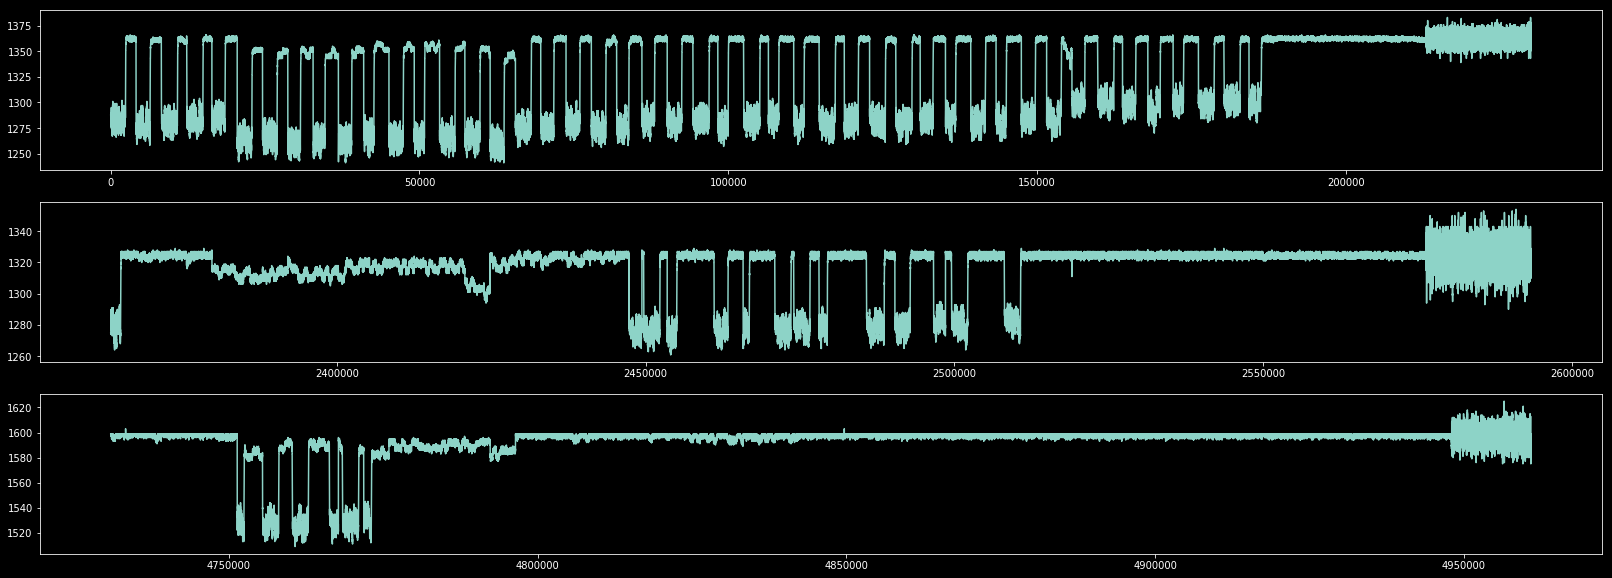

In [ ]:
for i,ax in plot_flat(3,1, figsize=(28,10)):
    ax.plot(df_left[(df_left.axis==i) & (df_left.class_label==1)].value[:230000])

The data looks weird at the very beginning for some unknwon reason, let's manually cut out the part before `[217000]`

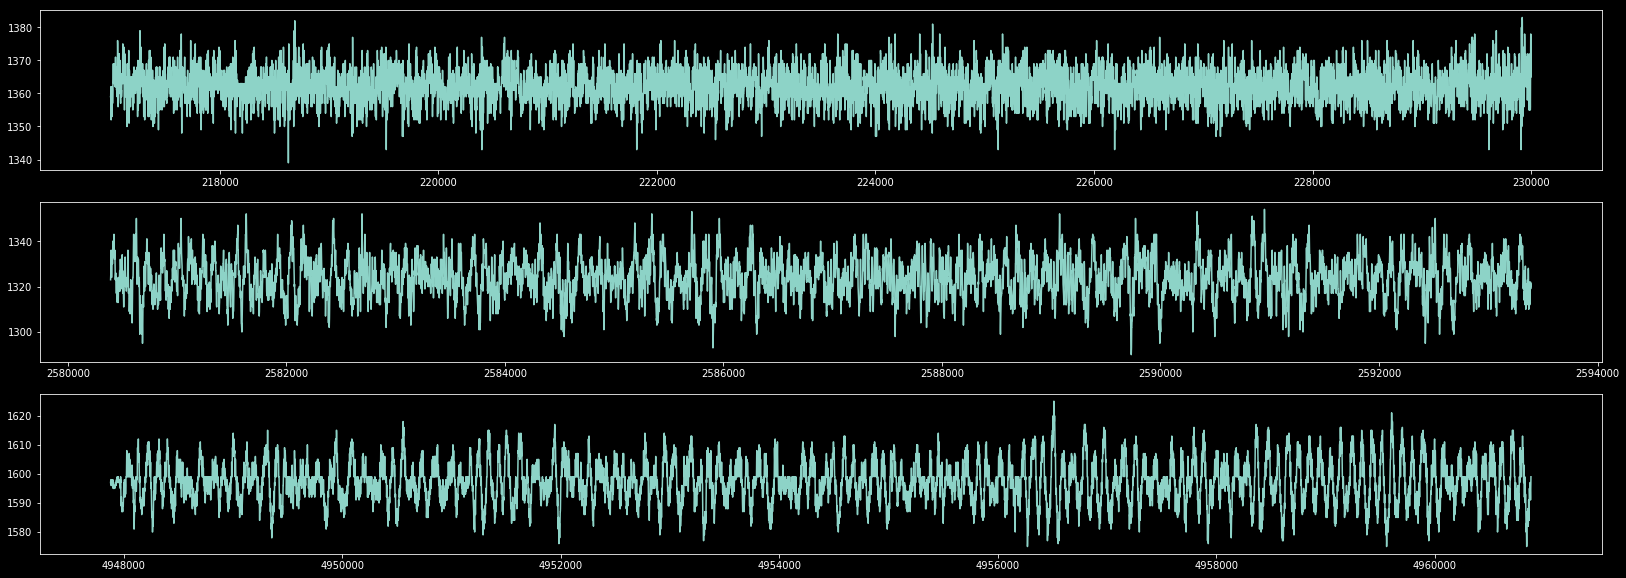

In [ ]:
trunc_idx = 217000
for i,ax in plot_flat(3,1, figsize=(28,10)):
    ax.plot(df_left[(df_left.axis==i) & (df_left.class_label==1)].value[trunc_idx:230000])

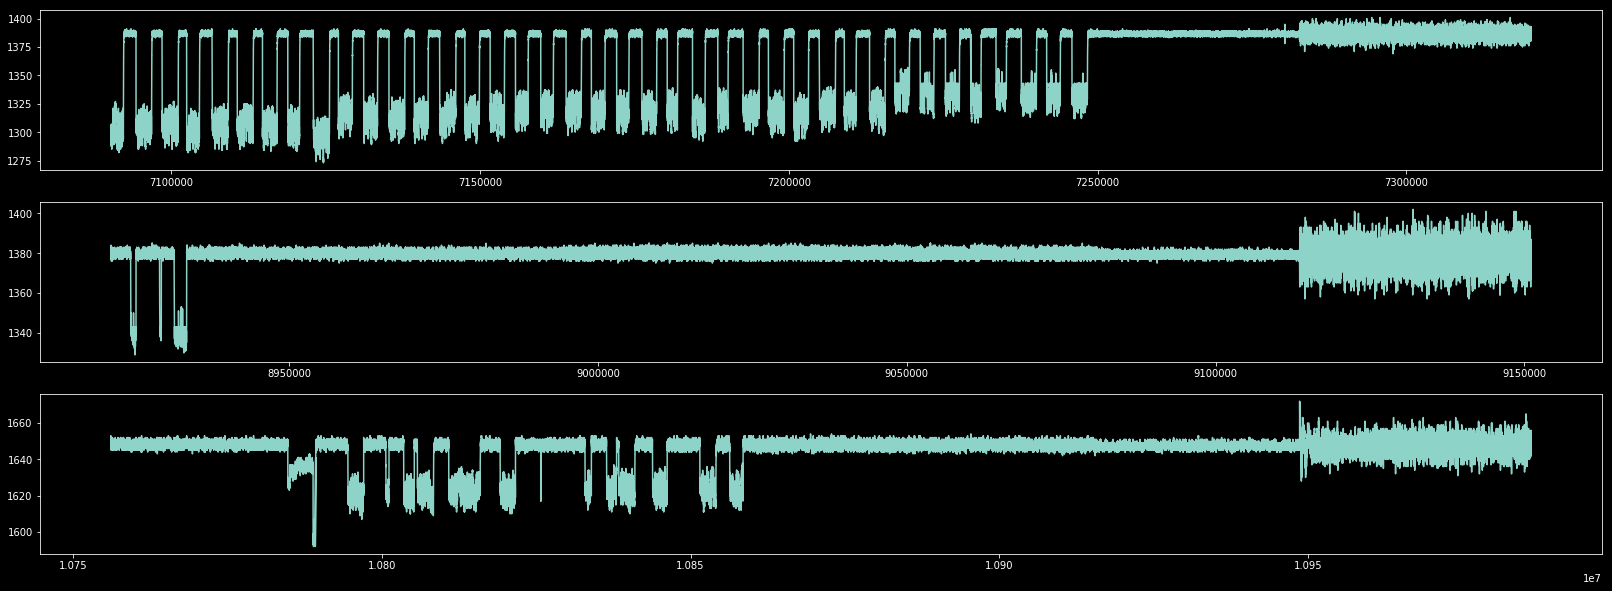

In [ ]:
for i,ax in plot_flat(3,1, figsize=(28,10)):
    ax.plot(df_right[(df_right.axis==i) & (df_right.class_label==1)].value[:230000])

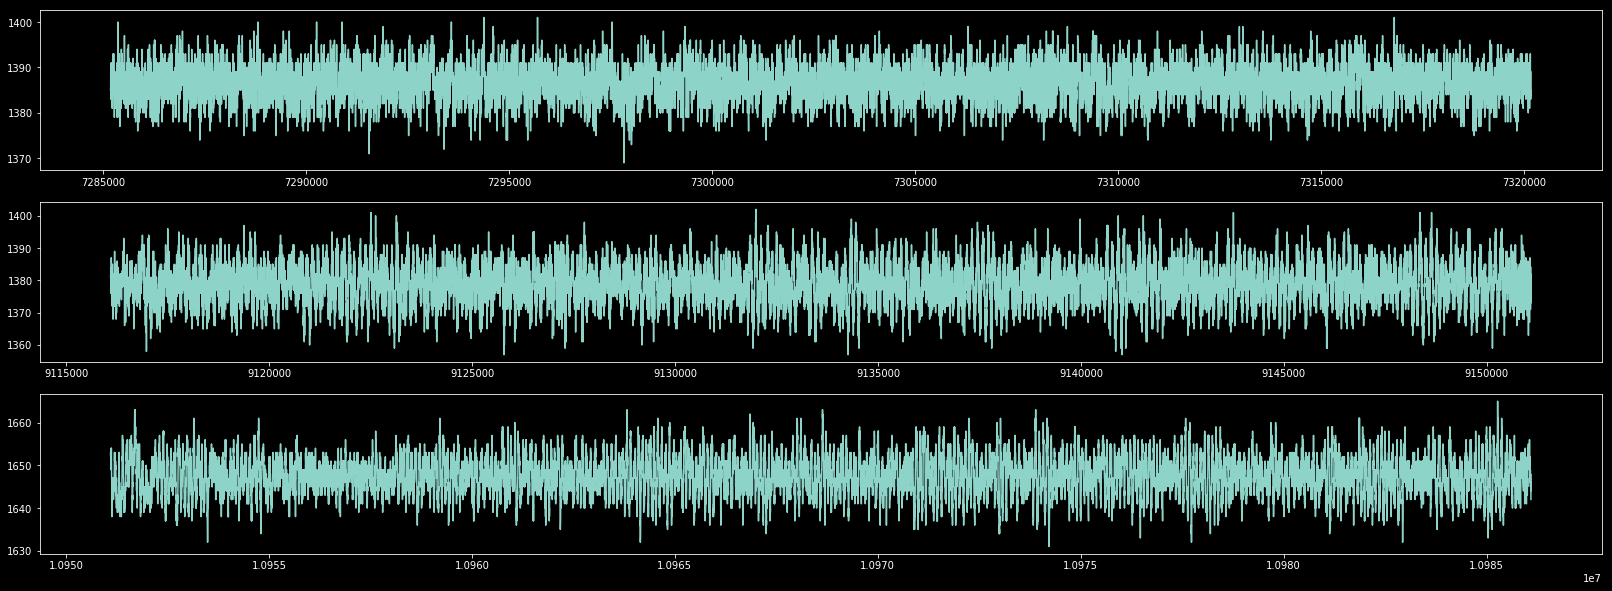

In [ ]:
trunc_idx = 195000
for i,ax in plot_flat(3,1, figsize=(28,10)):
    ax.plot(df_right[(df_right.axis==i) & (df_right.class_label==1)].value[trunc_idx:230000])

In [ ]:
#export
def feature_normalize(data):
    "Mean-std normalization"
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data-mu)/sigma

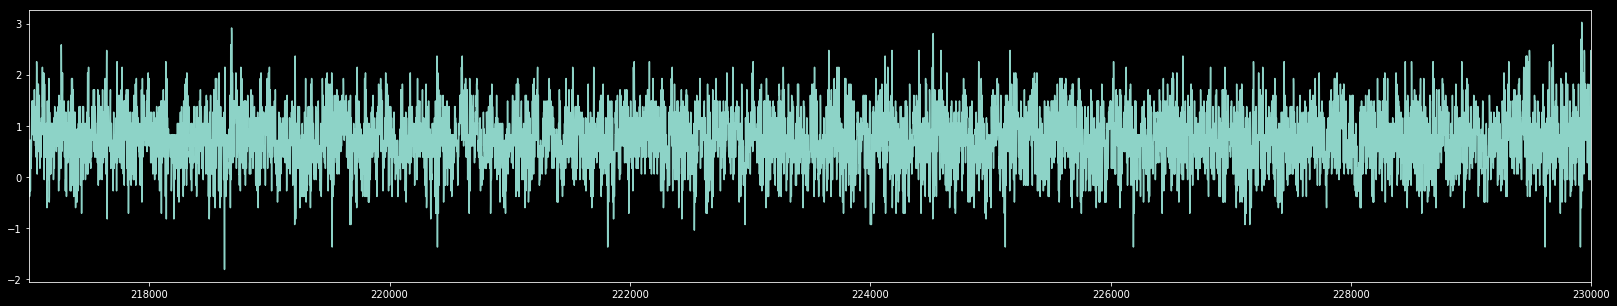

In [ ]:
df_left_x = df_left[df_left.axis==0].iloc[trunc_idx:]
df_left_x.loc[:,'value'] = feature_normalize(df_left_x.loc[:,'value'])
df_left_x.value[:13000].plot(figsize=(28,5))

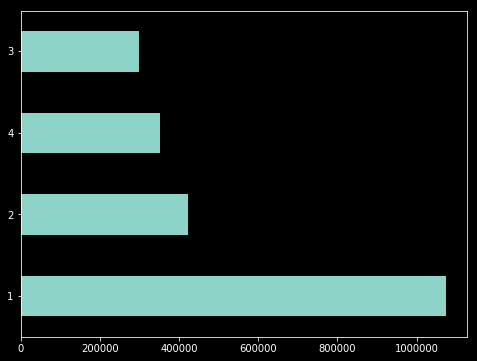

In [ ]:
df_left_x.class_label.value_counts().plot.barh(figsize=(8,6))

In [ ]:
tmp = df_left_x.class_label.value_counts()
lut = 1/(max(tmp-90)/(tmp-90)); lut

1    1.000000
2    0.393047
4    0.328161
3    0.278543
Name: class_label, dtype: float64

In [ ]:
cat = df_left_x.class_label.unique()
des = ['Normal','Bushing down','Bearing down','Both down']
id2desc = dict(zip(cat,des)); id2desc

{1: 'Normal', 2: 'Bushing down', 3: 'Bearing down', 4: 'Both down'}

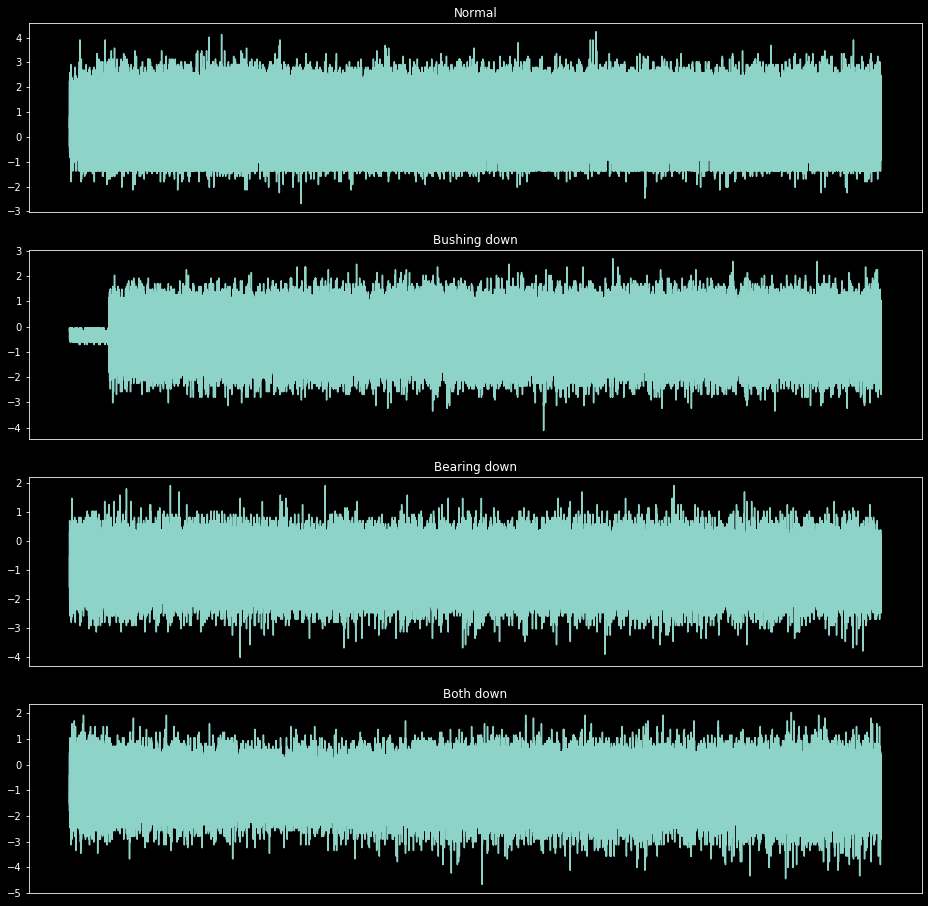

In [ ]:
for (i,ax),c in zip(plot_flat(4,1,figsize=(16,16)), np.unique(df_left_x['class_label'])):
    subset = df_left_x[df_left_x['class_label']==c]
    ax.plot(subset.value)
    ax.set_title(id2desc[c])
    ax.xaxis.set_visible(False)
    #ax.yaxis.set_visible(False)
    #ax.grid(True)

In [ ]:
df_left_x.class_label.unique()

array([1, 2, 3, 4])

In [ ]:
#export
def windows(data, size, step=1):
    "With window size and step ratio, yield window start and stop index"
    start = 0
    while start < len(data):
        yield int(start), int(start+size)
        start += (size*step)

from scipy import stats
def segment_signal(dataset, window_size=90):
    "Retrun segments in shape of (n_items, window_size, channel) and \
            labels in shape of (n_items,)"
    #segments = np.empty((0,window_size,3))
    segments = np.empty((0,window_size))
    x_train = np.empty((0,window_size))
    x_test = np.empty((0,window_size))
    labels = np.empty((0))
    y_train = np.empty((0))
    y_test = np.empty((0))
    
    # hack
    for c in dataset.class_label.unique():
        #print(c)
        data = dataset[dataset.class_label == c]
        #import pdb; pdb.set_trace()

        for (start, end) in windows(data,window_size,lut[c]):
            #x = data['x-axis'][start:end]
            x = data['value'][start:end]
            #y = data['y-axis'][start:end]
            #z = data['z-axis'][start:end]
            if(len(data[start:end]) == window_size):
                #segments = np.vstack([segments,np.dstack([x,y,z])])
                segments = np.vstack([segments,x])
                # Take the mode of a window array as the label
                labels = np.append(labels,stats.mode(data['class_label'][start:end])[0][0])

    return segments, labels

def feature_normalize(dataset):
    "Mean-std normalization"
    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset-mu)/sigma

def plot_losses(history):
    for (i,ax),(a,b) in zip(plot_flat(1, 2, figsize=(16,6)), (('val_loss','loss'),('val_acc', 'acc'))):
        ax.plot(history.history[a])
        ax.plot(history.history[b])
        ax.legend(['val','train'], loc='upper left')
          
from sklearn.metrics import confusion_matrix as cm
import seaborn as sns
def show_confusion_matrix(validations, predictions):

    matrix = cm(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=des,
                yticklabels=des,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

In [ ]:
#export
from matplotlib import pyplot as plt
import math
from keras.callbacks import LambdaCallback
import keras.backend as K

class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """
    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if math.isnan(loss) or loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1):
        num_batches = epochs * x_train.shape[0] / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                        batch_size=batch_size, epochs=epochs,
                        callbacks=[callback])

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def find_generator(self, generator, start_lr, end_lr, epochs=1, steps_per_epoch=None, **kw_fit):
            if steps_per_epoch is None:
                try:
                    steps_per_epoch = len(generator)
                except (ValueError, NotImplementedError) as e:
                    raise e('`steps_per_epoch=None` is only valid for a'
                            ' generator based on the '
                            '`keras.utils.Sequence`'
                            ' class. Please specify `steps_per_epoch` '
                            'or use the `keras.utils.Sequence` class.')
            self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(steps_per_epoch))

            # Save weights into a file
            self.model.save_weights('tmp.h5')

            # Remember the original learning rate
            original_lr = K.get_value(self.model.optimizer.lr)

            # Set the initial learning rate
            K.set_value(self.model.optimizer.lr, start_lr)

            callback = LambdaCallback(on_batch_end=lambda batch,
                                      logs: self.on_batch_end(batch, logs))

            self.model.fit_generator(generator=generator,
                                     epochs=epochs,
                                     steps_per_epoch=steps_per_epoch,
                                     callbacks=[callback],
                                     **kw_fit)

            # Restore the weights to the state before model fitting
            self.model.load_weights('tmp.h5')

            # Restore the original learning rate
            K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale('log')

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivative = (self.losses[i] - self.losses[i - sma]) / sma
            derivatives.append(derivative)

        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], derivatives[n_skip_beginning:-n_skip_end])
        plt.xscale('log')
        plt.ylim(y_lim)

In [ ]:
#export
def evaluate_ram(model, byte_per_unit=2):
    msum = 0
    for layer in model.layers:  
        lsum = 1
        for dim in layer.output.shape:
            if dim.value != None:
                lsum *= dim.value
        msum += lsum
    return msum * byte_per_unit

def human_format(num):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    # add more suffixes if you need them
    return '%.2f%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])

In [ ]:
segments, labels = segment_signal(df_left_x)

In [ ]:
clabels = np.asarray(pd.get_dummies(labels),dtype = np.int8)

In [ ]:
#ni,nrow,ncol = segments.shape
ni,nrow = segments.shape
nlabel = clabels.shape[1]

In [ ]:
segments.shape, labels.shape, clabels.shape

((47696, 90), (47696,), (47696, 4))

In [ ]:
#for i,axs in plot_flat(3,1, figsize=(20,8)):
#    axs.plot(segments[1,:,i])

In [ ]:
#train = segments.reshape(ni, nrow, ncol, 1)
train = segments.reshape(ni, nrow); train.shape

(47696, 90)

In [ ]:
val_pct = 0.2
#to_keep = np.random.rand(len(train)) > val_pct

In [ ]:
to_keep = (np.array(range(int(len(labels)/4))) / int((len(labels)/4)*(1-val_pct))) < 1
to_keep = np.hstack(4*[to_keep])

In [ ]:
x_train, y_train = np.nan_to_num(train[to_keep]), clabels[to_keep]
x_test, y_test = np.nan_to_num(train[~to_keep]), clabels[~to_keep]

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38156, 90), (38156, 4), (9540, 90), (9540, 4))

In [ ]:
from keras.models import Sequential
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, \
                         Flatten, Dropout, BatchNormalization, Reshape,     \
                         GlobalAveragePooling1D, GlobalAveragePooling2D
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint, EarlyStopping

from scipy import stats
from sklearn.model_selection import train_test_split

# Models

## Model #1 : Pure Dense Layers

In [ ]:
#experiment = Experiment(api_key="cbo2O7WzZESmb90XubLZ3deW9",project_name="general", workspace="austinyhc")

### hyper-parameters

In [ ]:
val_pct = 0.2
eps,bs = 100,512

params = {
    "batch_size" : bs,
    "epochs"     : eps
}

In [ ]:
cbs = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, min_delta=1e-4, min_lr=1e-9, patience=6, verbose=1),
    ModelCheckpoint(filepath="0-best-dense.h5", monitor="val_loss", save_best_only=True, verbose=1),
    #EarlyStopping(patience=12, verbose=1)
]

### model

In [ ]:
del model; gc.collect()
model = Sequential()

model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dense(196, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='softmax'))
adam = Adam(lr=3e-4, decay=1e-6)

model.compile(optimizer=adam,loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()
print(f"RAM: {human_format(evaluate_ram(model))}")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_214 (Dense)            (None, 64)                5824      
_________________________________________________________________
dense_215 (Dense)            (None, 64)                4160      
_________________________________________________________________
batch_normalization_41 (Batc (None, 64)                256       
_________________________________________________________________
dense_216 (Dense)            (None, 128)               8320      
_________________________________________________________________
dense_217 (Dense)            (None, 196)               25284     
_________________________________________________________________
dense_218 (Dense)            (None, 32)                6304      
_________________________________________________________________
dense_219 (Dense)            (None, 4)                 132       
Total para

In [ ]:
lr_finder = LRFinder(model)
lr_finder.find(x_train, y_train, start_lr=1e-7, end_lr=1, batch_size=512, epochs=5)

Epoch 1/5
20152/20152 [==============================] - 3s 142us/step - loss: 1.4579 - acc: 0.2708
Epoch 2/5
20152/20152 [==============================] - 0s 13us/step - loss: 1.4396 - acc: 0.2775
Epoch 3/5
20152/20152 [==============================] - 0s 15us/step - loss: 1.3075 - acc: 0.3731
Epoch 4/5
20152/20152 [==============================] - 0s 18us/step - loss: 1.0058 - acc: 0.5317
Epoch 5/5
 7168/20152 [=========>....................] - ETA: 0s - loss: 1.0425 - acc: 0.5193

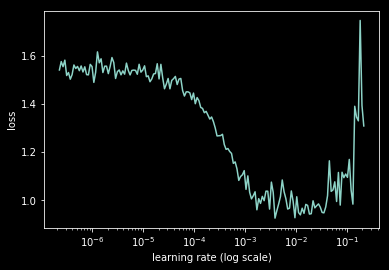

In [ ]:
lr_finder.plot_loss()

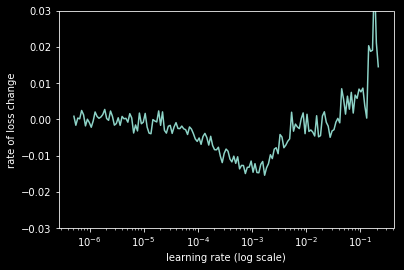

In [ ]:
lr_finder.plot_loss_change(sma=20, n_skip_beginning=20, n_skip_end=5, y_lim=(-0.03, 0.03))

### train

In [ ]:
#with experiment.train():
history = model.fit(x_train, y_train, 
                    epochs=eps, batch_size=bs, 
                    validation_split=val_pct,
                    callbacks=cbs, verbose=1)

Train on 30524 samples, validate on 7632 samples
Epoch 1/100
30524/30524 [==============================] - 4s 116us/step - loss: 0.6403 - acc: 0.8107 - val_loss: 2.4789 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 2.47894, saving model to 0-best-dense.h5
Epoch 2/100
30524/30524 [==============================] - 0s 11us/step - loss: 0.2663 - acc: 0.9060 - val_loss: 1.7693 - val_acc: 0.0096

Epoch 00002: val_loss improved from 2.47894 to 1.76930, saving model to 0-best-dense.h5
Epoch 3/100
30524/30524 [==============================] - 0s 12us/step - loss: 0.2252 - acc: 0.9133 - val_loss: 1.3994 - val_acc: 0.2258

Epoch 00003: val_loss improved from 1.76930 to 1.39937, saving model to 0-best-dense.h5
Epoch 4/100
30524/30524 [==============================] - 0s 12us/step - loss: 0.1934 - acc: 0.9269 - val_loss: 1.4449 - val_acc: 0.3506

Epoch 00004: val_loss did not improve from 1.39937
Epoch 5/100
30524/30524 [==============================] - 0s 12us/step - loss:

### evaluation

In [ ]:
# with experiment.test():
#     loss,accuracy = model.evaluate(x_test, y_test, verbose=0)
#     print(f'Accuracy: {accuracy*100}%')
#     metrics = {
#         "loss": loss,
#         "accuracy": accuracy
#     }
#     experiment.log_metrics(metrics)

In [ ]:
loss,accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f'Accuracy: {accuracy*100}%')

Accuracy: 89.89517819706498%


In [ ]:
#experiment.log_parameters(params)
#experiment.log_dataset_hash(x_train)

In [ ]:
y_pred_test = model.predict(x_test)
y_pred_test = np.argmax(y_pred_test, axis=1)
y_gt_test = np.argmax(y_test, axis=1)

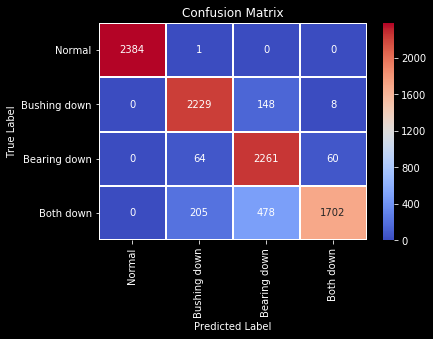

In [ ]:
show_confusion_matrix(y_gt_test, y_pred_test)

Wow, that is beyond my imagination. The result is surprisingly not bad, `89.89%`. I did not do any feature engineering or word embeddings, or any fancy model, just a few fully connected layers with time series data point.
- If you do the split after using shifting window sampling to increase data quantity, you must beware of data leakage.

## Model #2 : Pure Conv1D Layers

In [ ]:
x_train = x_train.reshape(x_train.shape[0], 90)

In [ ]:
x_train.shape

(38156, 90)

### model

In [ ]:
del model_2; gc.collect()
model_2 = Sequential()
model_2.add(Reshape((90, 1), input_shape=(90,)))
model_2.add(Conv1D(100, 15, activation='relu', input_shape=(90, 1)))
model_2.add(Conv1D(100, 15, activation='relu', use_bias=False))
model_2.add(BatchNormalization())
model_2.add(MaxPooling1D(2))
model_2.add(Conv1D(60, 8, activation='relu'))
model_2.add(Conv1D(60, 8, activation='relu', use_bias=False))
model_2.add(BatchNormalization())
model_2.add(GlobalAveragePooling1D())
model_2.add(Dropout(0.25))
model_2.add(Dense(512, activation='relu', use_bias=False))
model_2.add(Dropout(0.25))
model_2.add(Dense(4, activation='softmax'))
adam = Adam(lr=6e-5, decay=1e-6)
model_2.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model_2.summary()
print(f"RAM: {human_format(evaluate_ram(model_2))}")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_38 (Reshape)         (None, 90, 1)             0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 76, 100)           1600      
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 62, 100)           150000    
_________________________________________________________________
batch_normalization_44 (Batc (None, 62, 100)           400       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 31, 100)           0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 24, 60)            48060     
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 17, 60)            28800     
__________

In [ ]:
lr_finder = LRFinder(model_2)
lr_finder.find(x_train, y_train, start_lr=1e-7, end_lr=1, batch_size=512, epochs=5)

Epoch 1/5
38156/38156 [==============================] - 2s 52us/step - loss: 1.3033 - acc: 0.3798
Epoch 2/5
38156/38156 [==============================] - 1s 39us/step - loss: 1.0790 - acc: 0.5545
Epoch 3/5
38156/38156 [==============================] - 1s 39us/step - loss: 0.5187 - acc: 0.7870
Epoch 4/5
38156/38156 [==============================] - 1s 38us/step - loss: 0.3091 - acc: 0.8781
Epoch 5/5
 8192/38156 [=====>........................] - ETA: 1s - loss: 0.5082 - acc: 0.8235

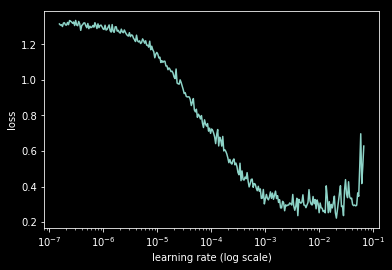

In [ ]:
lr_finder.plot_loss()

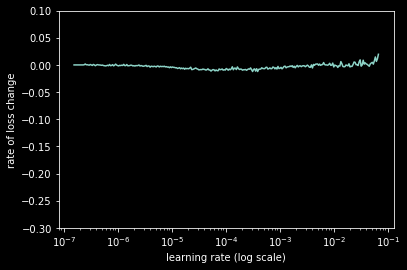

In [ ]:
lr_finder.plot_loss_change(sma=20, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.3, 0.1))

### hyper-params

In [ ]:
val_pct = 0.2
eps,bs = 100,512

params = {
    "batch_size" : bs,
    "epochs"     : eps
}

In [ ]:
cbs = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, min_delta=1e-4, min_lr=1e-9, patience=6, verbose=1),
    ModelCheckpoint(filepath="0-best-conv1d.h5", monitor="val_loss", save_best_only=True, verbose=1),
    #EarlyStopping(patience=10, verbose=1, mode='min')
]

### train

In [ ]:
with experiment.train():
    history = model_2.fit(x_train, y_train, 
                    epochs=eps, batch_size=bs, 
                    validation_split=val_pct,
                    callbacks=cbs, verbose=1)

Train on 30524 samples, validate on 7632 samples
Epoch 1/100
30524/30524 [==============================] - 2s 65us/step - loss: 0.6888 - acc: 0.8111 - val_loss: 2.1319 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 2.13185, saving model to 0-best-conv1d.h5
Epoch 2/100
30524/30524 [==============================] - 1s 40us/step - loss: 0.3920 - acc: 0.8738 - val_loss: 2.0758 - val_acc: 0.0000e+00

Epoch 00002: val_loss improved from 2.13185 to 2.07581, saving model to 0-best-conv1d.h5
Epoch 3/100
30524/30524 [==============================] - 1s 40us/step - loss: 0.3271 - acc: 0.8884 - val_loss: 1.9679 - val_acc: 0.0109

Epoch 00003: val_loss improved from 2.07581 to 1.96787, saving model to 0-best-conv1d.h5
Epoch 4/100
30524/30524 [==============================] - 1s 40us/step - loss: 0.2916 - acc: 0.8952 - val_loss: 1.9768 - val_acc: 0.0905

Epoch 00004: val_loss did not improve from 1.96787
Epoch 5/100
30524/30524 [==============================] - 1s 41us/step -

### evaluation

In [ ]:
with experiment.test():
    loss,accuracy = model_2.evaluate(x_test, y_test, verbose=0)
    print(f'Accuracy: {accuracy*100}%')
    metrics = {
        "loss": loss,
        "accuracy": accuracy
    }
    experiment.log_metrics(metrics)

Accuracy: 89.62264150943396%


In [ ]:
y_pred_test = model_2.predict(x_test)
y_pred_test = np.argmax(y_pred_test, axis=1)
y_gt_test = np.argmax(y_test, axis=1)

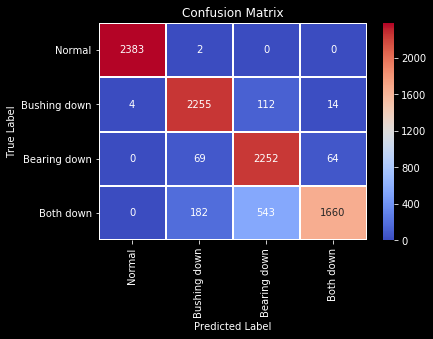

In [ ]:
show_confusion_matrix(y_gt_test, y_pred_test)

## Model #3 : Conv1D + Conv2D 

### model

In [ ]:
del model_3; gc.collect()
model_3 = Sequential()
model_3.add(Reshape((90, 1), input_shape=(90,)))
model_3.add(Conv1D(100, 15, activation='relu', input_shape=(90, 1)))
model_3.add(Reshape((76, 100, 1)))
model_3.add(Conv2D(100, kernel_size=(3,3), activation='relu'))
model_3.add(Conv2D(100, kernel_size=(3,3), activation='relu', use_bias=False))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(3))
model_3.add(Conv2D(60, kernel_size=(3,3), activation='relu'))
model_3.add(Conv2D(60, kernel_size=(3,3), activation='relu', use_bias=False))
model_3.add(BatchNormalization())
model_3.add(GlobalAveragePooling2D())
model_3.add(Dropout(0.25))
model_3.add(Dense(512, activation='relu', use_bias=False))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.25))
model_3.add(Dense(4, activation='softmax'))
adam = Adam(lr=2e-5, decay=1e-6)
model_3.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_27 (Reshape)         (None, 90, 1)             0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 76, 100)           1600      
_________________________________________________________________
reshape_28 (Reshape)         (None, 76, 100, 1)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 74, 98, 100)       1000      
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 72, 96, 100)       90000     
_________________________________________________________________
batch_normalization_58 (Batc (None, 72, 96, 100)       400       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 24, 32, 100)       0         
__________

In [ ]:
lr_finder = LRFinder(model_3)
lr_finder.find(x_train, y_train, start_lr=1e-7, end_lr=1, batch_size=256, epochs=2)

Epoch 1/2
38156/38156 [==============================] - 44s 1ms/step - loss: 1.5013 - acc: 0.4195
Epoch 2/2
31744/38156 [=======================>......] - ETA: 7s - loss: 0.5878 - acc: 0.7560

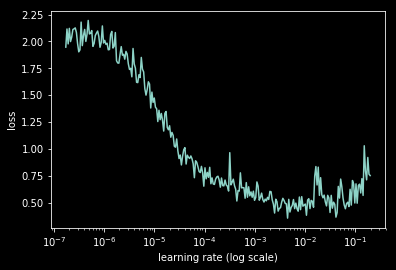

In [ ]:
lr_finder.plot_loss()

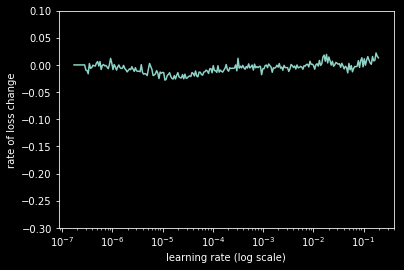

In [ ]:
lr_finder.plot_loss_change(sma=20, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.3, 0.1))

### hyper-params 

In [ ]:
val_pct = 0.2
eps,bs = 100,384

params = {
    "batch_size" : bs,
    "epochs"     : eps
}

In [ ]:
cbs = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, min_delta=1e-4, min_lr=1e-9, patience=6, verbose=1),
    ModelCheckpoint(filepath="0-best-conv1d+2d.h5", monitor="val_loss", save_best_only=True, verbose=1),
    EarlyStopping(patience=10, verbose=1, mode='min')
]

### train

In [ ]:
with experiment.train():
    history = model_3.fit(x_train, y_train, 
                    epochs=eps, batch_size=bs, 
                    validation_split=val_pct,
                    callbacks=cbs, verbose=1)

Train on 30524 samples, validate on 7632 samples
Epoch 1/100
30524/30524 [==============================] - 44s 1ms/step - loss: 0.8902 - acc: 0.6789 - val_loss: 1.9355 - val_acc: 0.0014

Epoch 00001: val_loss did not improve from 0.71001
Epoch 2/100
30524/30524 [==============================] - 39s 1ms/step - loss: 0.4318 - acc: 0.8574 - val_loss: 1.6550 - val_acc: 0.0444

Epoch 00002: val_loss did not improve from 0.71001
Epoch 3/100
30524/30524 [==============================] - 39s 1ms/step - loss: 0.3889 - acc: 0.8665 - val_loss: 2.1942 - val_acc: 0.0371

Epoch 00003: val_loss did not improve from 0.71001
Epoch 4/100
30524/30524 [==============================] - 39s 1ms/step - loss: 0.3686 - acc: 0.8732 - val_loss: 2.0167 - val_acc: 0.0203

Epoch 00004: val_loss did not improve from 0.71001
Epoch 5/100
30524/30524 [==============================] - 39s 1ms/step - loss: 0.3538 - acc: 0.8756 - val_loss: 2.1266 - val_acc: 0.0012

Epoch 00005: val_loss did not improve from 0.71001
E

### evaluation

In [ ]:
with experiment.test():
    loss,accuracy = model_3.evaluate(x_test, y_test, verbose=0)
    print(f'Accuracy: {accuracy*100}%')
    metrics = {
        "loss": loss,
        "accuracy": accuracy
    }
    experiment.log_metrics(metrics)

Accuracy: 86.04821802935011%


In [ ]:
y_pred_test = model_3.predict(x_test)
y_pred_test = np.argmax(y_pred_test, axis=1)
y_gt_test = np.argmax(y_test, axis=1)

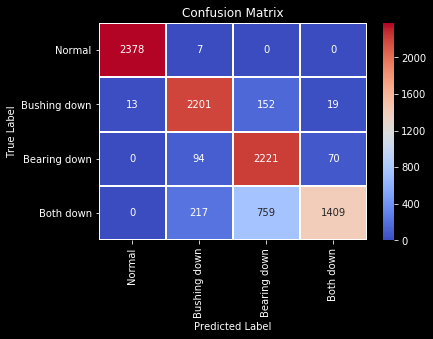

In [ ]:
show_confusion_matrix(y_gt_test, y_pred_test)

## Model #4 : Slimmed (Conv1D + Conv2D) 

### model

In [ ]:
del model_4; gc.collect()
model_4 = Sequential()
model_4.add(Reshape((90, 1), input_shape=(90,)))
model_4.add(Conv1D(100, 15, activation='relu', input_shape=(90, 1)))
model_4.add(Reshape((76, 100, 1)))
model_4.add(Conv2D(60, kernel_size=(3,3), activation='relu'))
model_4.add(Conv2D(60, kernel_size=(3,3), activation='relu', use_bias=False))
#model_4.add(BatchNormalization())
model_4.add(MaxPooling2D(3))
model_4.add(Conv2D(30, kernel_size=(3,3), activation='relu'))
model_4.add(Conv2D(30, kernel_size=(3,3), activation='relu', use_bias=False))
#model_4.add(BatchNormalization())
model_4.add(GlobalAveragePooling2D())
model_4.add(Dropout(0.25))
model_4.add(Dense(512, activation='relu', use_bias=False))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.25))
model_4.add(Dense(4, activation='softmax'))
adam = Adam(lr=2e-4, decay=1e-6)
model_4.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model_4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_17 (Reshape)         (None, 90, 1)             0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 76, 100)           1600      
_________________________________________________________________
reshape_18 (Reshape)         (None, 76, 100, 1)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 74, 98, 60)        600       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 72, 96, 60)        32400     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 24, 32, 60)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 22, 30, 30)        16230     
__________

In [ ]:
lr_finder = LRFinder(model_4)
lr_finder.find(x_train, y_train, start_lr=1e-7, end_lr=1, batch_size=256, epochs=2)

Epoch 1/2
38156/38156 [==============================] - 20s 511us/step - loss: 1.3366 - acc: 0.3113
Epoch 2/2
19456/38156 [==============>...............] - ETA: 8s - loss: 0.6806 - acc: 0.6598

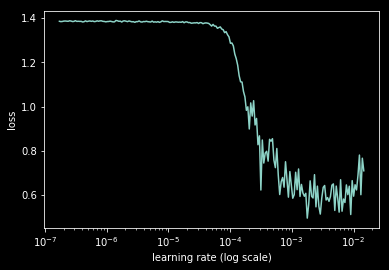

In [ ]:
lr_finder.plot_loss()

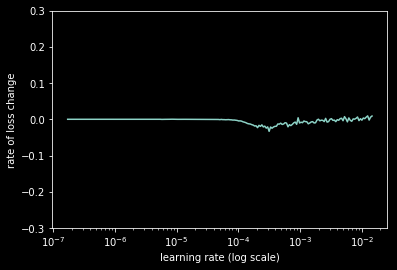

In [ ]:
lr_finder.plot_loss_change(sma=20, y_lim=(-0.3, 0.3))

### hyper-params

In [ ]:
val_pct = 0.2
eps,bs = 100,256

params = {
    "batch_size" : bs,
    "epochs"     : eps
}

In [ ]:
cbs = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, min_delta=1e-4, min_lr=1e-9, patience=6, verbose=1),
    ModelCheckpoint(filepath="0-best-conv1d+2d-slim.h5", monitor="val_loss", save_best_only=True, verbose=1),
    EarlyStopping(patience=15, verbose=1, mode='min')
]

### train

In [ ]:
#with experiment.train():
history = model_4.fit(x_train, y_train, 
                    epochs=eps, batch_size=bs, 
                    validation_split=val_pct,
                    callbacks=cbs, verbose=1)

Train on 30524 samples, validate on 7632 samples
Epoch 1/100
30524/30524 [==============================] - 16s 516us/step - loss: 0.7557 - acc: 0.6979 - val_loss: 2.0034 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 2.00338, saving model to 0-best-conv1d+2d-slim.h5
Epoch 2/100
30524/30524 [==============================] - 15s 484us/step - loss: 0.3765 - acc: 0.8713 - val_loss: 1.6842 - val_acc: 0.0000e+00

Epoch 00002: val_loss improved from 2.00338 to 1.68419, saving model to 0-best-conv1d+2d-slim.h5
Epoch 3/100
30524/30524 [==============================] - 15s 486us/step - loss: 0.3552 - acc: 0.8775 - val_loss: 2.2121 - val_acc: 0.0000e+00

Epoch 00003: val_loss did not improve from 1.68419
Epoch 4/100
30524/30524 [==============================] - 15s 491us/step - loss: 0.3487 - acc: 0.8796 - val_loss: 1.8352 - val_acc: 0.0000e+00

Epoch 00004: val_loss did not improve from 1.68419
Epoch 5/100
30524/30524 [==============================] - 15s 492us/step - los

### evaluation

In [ ]:
loss,accuracy = model_4.evaluate(x_test, y_test, verbose=0)
print(f'Accuracy: {accuracy*100}%')

Accuracy: 71.77148846960168%


In [ ]:
y_pred_test = model_4.predict(x_test)
y_pred_test = np.argmax(y_pred_test, axis=1)
y_gt_test = np.argmax(y_test, axis=1)

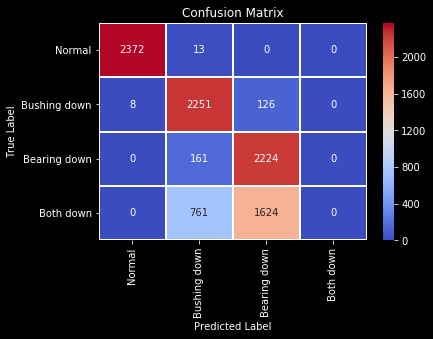

In [ ]:
show_confusion_matrix(y_gt_test, y_pred_test)

## Model #5: Transfer Learning - MobileNet v1

### model

In [ ]:
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
import numpy as np
from IPython.display import Image
from keras.optimizers import Adam

In [ ]:
mobile = keras.applications.mobilenet.MobileNet()
def prepare_image(file):
    img_path = ''
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [ ]:
Image(filename='German_Shepherd.jpg')

In [ ]:
base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(2,activation='softmax')(x) #final layer with softmax activation

In [ ]:
model=Model(inputs=base_model.input,outputs=preds)
#specify the inputs
#specify the outputs
#now a model has been created based on our architecture

In [ ]:
for i,layer in enumerate(model.layers):
    print(i,layer.name)

## TODOs
- [X] Keep using x-axis data only to train on 
- [X] Try `noramalization` on x-axis data and train on pure dense again
- [X] Fix data leakage
    - Honestly the result doesn't improve or drop after making right
- [ ] Try 3-axis data to train on pure dense
- [ ] Try x-axis data to train on easy conv

In [ ]:
#ni,nrow,ncol = segments.shape
ni,nrow = segments1.shape
nlabel = clabels.shape[1]
nch,nf = 1,128

kernel_sz = 2
pooling_sz = 2
nfc1,nfc2 = 128,128

val_pct = 0.2
eps,bs = 10,32
dropout = 0.5

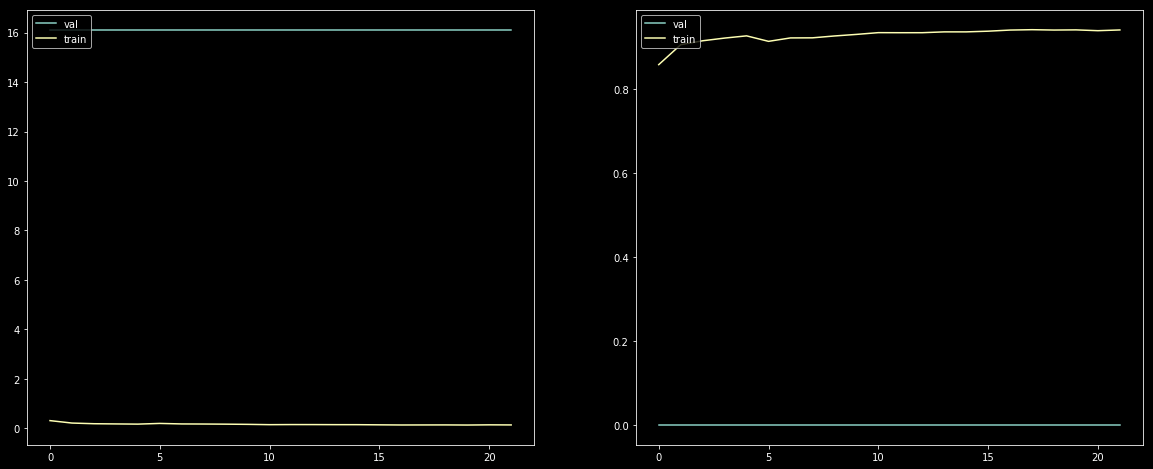

In [ ]:
for (i,ax),(a,b) in zip(plot_flat(1, 2, figsize=(20,8)), (('val_loss','loss'),('val_acc', 'acc'))):
    ax.plot(history.history[a])
    ax.plot(history.history[b])
    ax.legend(['val','train'], loc='upper left')